<a href="https://colab.research.google.com/github/mshaek/LoanPredictionApp/blob/main/notebooks/MoneyLion_Repayment_Mahfuzur_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part- 2: Model Training

In [59]:
#Import important Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [113]:
# Load the preprocessed data that was created after merging 'loan' and 'underwriting' dataset
data = pd.read_csv('https://raw.githubusercontent.com/mshaek/LoanPredictionApp/main/data/merged.csv')
data.head()

,apr,hasCF,target,Default_ratio_per_state,clearfraudscore,ssnLoanCount,HoursTaken,log_originallyScheduledPaymentAmount,log_loanAmount,log_nPaidOff,log_leadCost,payFrequency_B,payFrequency_I,payFrequency_M,payFrequency_S,payFrequency_W,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat
0,199.00,1,0,1.901639,879.0,1,17,8.763458,8.006701,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,590.00,1,0,1.901639,624.0,1,53,7.796913,6.685861,0.000000,2.397895,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,199.00,1,1,1.901639,831.0,1,115,8.802784,8.006701,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,251.00,1,0,1.901639,949.0,1,1,8.769717,7.863651,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,208.00,0,1,1.901639,854.0,1,1,8.986296,7.863651,0.693147,0.000000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29513,590.00,1,1,1.818182,765.0,1,1,7.223361,6.216606,0.000000,1.386294,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
29514,590.00,0,0,1.818182,729.0,1,0,6.774841,5.707110,1.098612,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
29515,645.00,1,1,1.818182,743.0,1,20,7.634622,6.398595,0.000000,1.945910,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
29516,29.99,0,0,0.000000,584.5,1,0,6.345987,6.272877,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [71]:
# Separate input features and target
x_data = data.drop(columns=['target'])
y_data = data['target'].astype('category')

In [72]:
# Shuffle and split data into 70% in training and 30% in testing
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_data, y_data,random_state=123, test_size=0.30)

In [73]:
# Create a dictionary to store accuracy and AUC scores of all models for visualization later
model_scores = {}

In [74]:
# Data Scaling is important for Neural Networks to prevent overfitting and exploding/vanishing gradient
from sklearn.preprocessing import QuantileTransformer
# created scaler
scaler = QuantileTransformer(output_distribution= 'normal', random_state=0)
# fit and transform training dataset
xtrain= scaler.fit_transform(xtrain)
# transform test dataset
xtest= scaler.transform(xtest)

In [75]:
xtrain

array([[-0.84090635, -5.19933758,  1.09784478, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 1.88775344,  5.19933758,  1.09784478, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 1.88775344,  5.19933758,  1.09784478, ...,  5.19933758,
        -5.19933758, -5.19933758],
       ...,
       [-0.24196303, -5.19933758,  2.32597246, ..., -5.19933758,
         5.19933758, -5.19933758],
       [ 1.18192052,  5.19933758,  0.56132709, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 0.20978711,  5.19933758,  1.44968225, ..., -5.19933758,
        -5.19933758, -5.19933758]])

## Data Modelling and Parameter Tuning
* 4 models has been used to perform data modelling. These are Random Forest, XGBoost, Logistic Regression and Neural Networks.
* Feature selection is not needed for Random Forest and XGBoost.
* Random Forest and XGBoost are robust to the outliers
* Confusion Matrix will be shown and Cross-validation will be performed. 
* Model Performance will be compared using AUC score on validation dataset

In [76]:
# function for evaluation metrics
def model_evaluation(model, ytest, y_pred, plot=False):
    '''
    This function is used to calculate evaluation metrics
    '''
# Confusion Marix and Visualisations
    confusion = confusion_matrix(ytest, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    accuracy = metrics.accuracy_score(ytest, y_pred)
    print('TP:', TP)
    print('TN:', TN)
    print('FP:', FP)
    print('FN:', FN)
    
    AUC= metrics.roc_auc_score(ytest, y_pred)
    #CV_AUC = cross_val_score(model, x_data, y_data, cv=10, scoring='roc_auc').mean()
    print('Classification Accuracy:', accuracy)    
    print('F1 Score:',f1_score(ytest, y_pred))
    print('AUC Score:',AUC)
    #print('Cross-validated AUC:', CV_AUC)
  
    return accuracy, AUC

## Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss,f1_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# Building and fitting random_forest
random_forest =RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 50, random_state = 123)
random_forest.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

########### Random Forests ###############


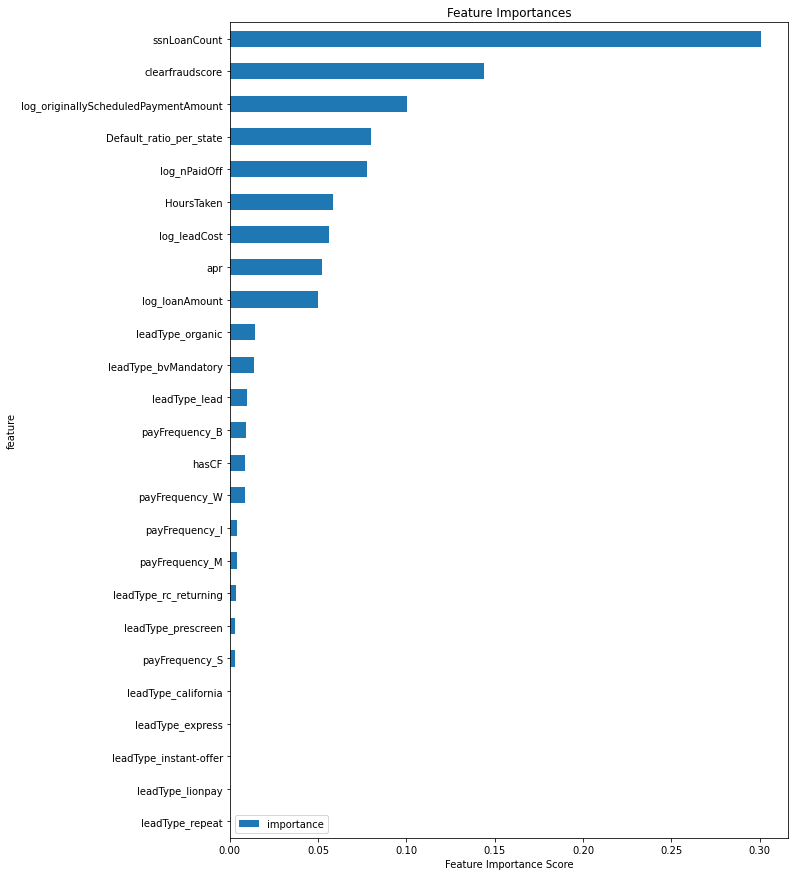

In [112]:
print('########### Random Forests ###############')
feat_imp = pd.DataFrame({'importance':random_forest.feature_importances_})    
feat_imp['feature'] = x_data.columns
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="Feature Importances", figsize=(10,15))
plt.xlabel('Feature Importance Score')
plt.show()

In [79]:
# make class predictions for the testing set
y_pred_class_rf = random_forest.predict(xtest)

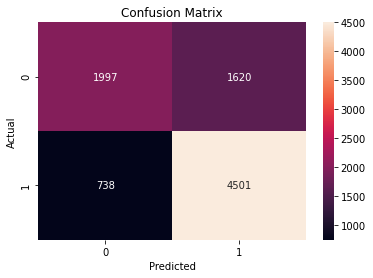

TP: 4501
TN: 1997
FP: 1620
FN: 738
Classification Accuracy: 0.733739837398374
F1 Score: 0.7924295774647887
AUC Score: 0.7056242174250533


In [80]:
accuracy_score_random_forest = model_evaluation(random_forest, ytest, y_pred_class_rf, True)

# Saving AUC score to the model_scores dictionary
model_scores['Random Forest'] = accuracy_score_random_forest[1] * 100

## XGBoost

In [81]:
from scipy.stats import randint
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
xgModel = XGBClassifier()
xgModel.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

########### XGBoost ###############


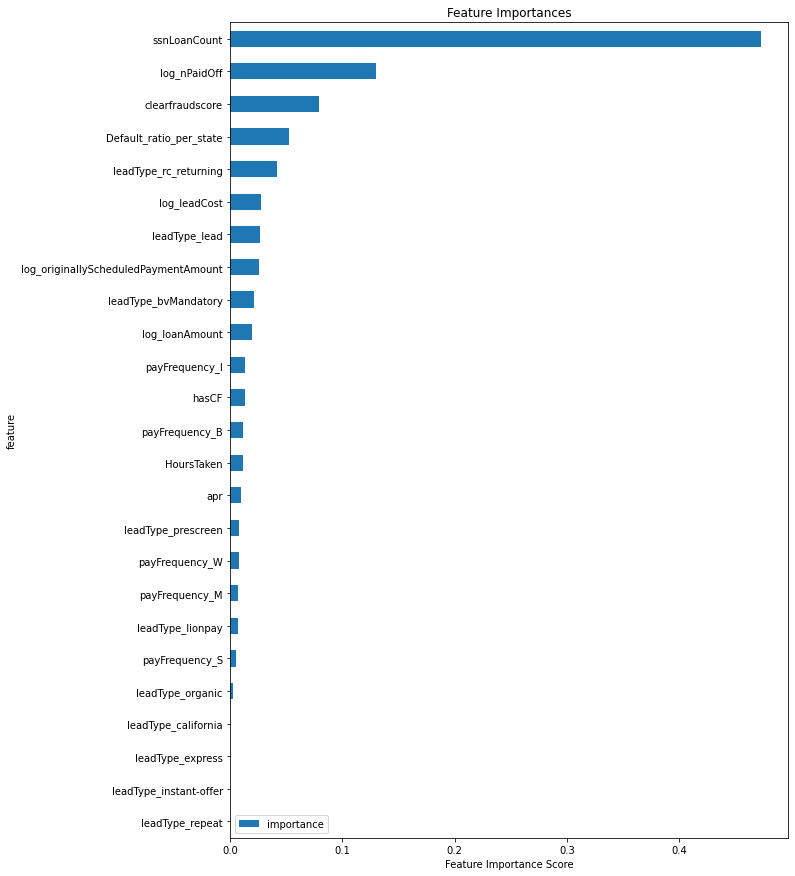

In [111]:
print('########### XGBoost ###############')
feat_imp = pd.DataFrame({'importance':xgModel.feature_importances_})    
feat_imp['feature'] = x_data.columns
feat_imp.sort_values(by='importance', ascending=True, inplace=True)

feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="Feature Importances", figsize=(10,15))
plt.xlabel('Feature Importance Score')
plt.show()

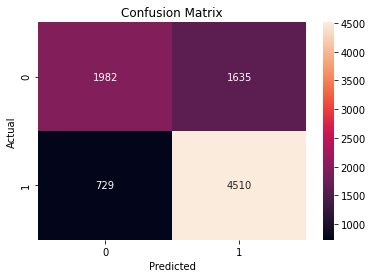

TP: 4510
TN: 1982
FP: 1635
FN: 729
Classification Accuracy: 0.7330623306233063
F1 Score: 0.7923401264933239
AUC Score: 0.7044096183622723


In [83]:
# make class predictions for the testing set
y_pred_xgModel = xgModel.predict(xtest)

accuracy_score = model_evaluation(xgModel, ytest, y_pred_xgModel, True)

model_scores['XGBClassifier'] = accuracy_score[1] * 100

In [84]:
#Hyperparameter tuning of XGBoost Classifier
param_distributions={'max_depth': np.arange(1, 5,1),
                    'subsample': uniform(0.25, 0.75),
                    'colsample_bytree': uniform(0.25, 0.75),
                    "learning_rate": [0.05, 0.1,0.16]
                    }

rs = RandomizedSearchCV(xgModel,
                        param_distributions,
                        cv=10,
                        n_iter=10,
                        scoring="accuracy",
                        n_jobs=1,
                        verbose=False,
                        random_state=123)
rs.fit(xtrain, ytrain)
y_pred_xgModel_cv = rs.predict(xtest)


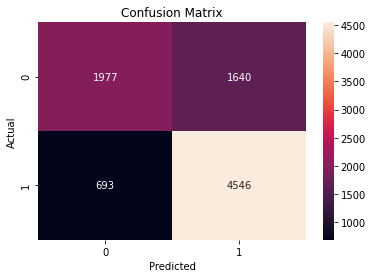

TP: 4546
TN: 1977
FP: 1640
FN: 693
Classification Accuracy: 0.7365627822944896
F1 Score: 0.7957986870897157
AUC Score: 0.707154208011066


In [85]:
model_score_xgboost_cv= model_evaluation(rs, ytest, y_pred_xgModel_cv, True)
model_scores['XGBoost_CV'] = model_score_xgboost_cv[1] * 100

In [86]:
rs.best_params_

{'colsample_bytree': 0.47028553479162205,
 'learning_rate': 0.05,
 'max_depth': 4,
 'subsample': 0.3190787049588064}

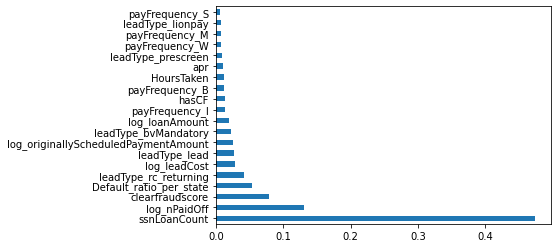

In [87]:
#plot graph of feature importances for better visualization
from xgboost import plot_importance
feat_importances = pd.Series(xgModel.feature_importances_, index=x_data.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [88]:
rs.best_params_

{'colsample_bytree': 0.47028553479162205,
 'learning_rate': 0.05,
 'max_depth': 4,
 'subsample': 0.3190787049588064}

## Logistic Regression

In [89]:
from sklearn.linear_model import LogisticRegression
logistic_reg= LogisticRegression()
logistic_reg.fit(xtrain, ytrain)
y_pred_class = logistic_reg.predict(xtest)
logistic_reg.score(xtest,ytest)

0.7275293586269196

Feature: 0, Score: 0.03883
Feature: 1, Score: -0.03400
Feature: 2, Score: 0.25287
Feature: 3, Score: -0.49077
Feature: 4, Score: -0.38110
Feature: 5, Score: -0.07402
Feature: 6, Score: 0.23152
Feature: 7, Score: 0.06401
Feature: 8, Score: 0.07553
Feature: 9, Score: -0.18127
Feature: 10, Score: 0.04751
Feature: 11, Score: -0.01201
Feature: 12, Score: 0.01198
Feature: 13, Score: 0.01299
Feature: 14, Score: 0.05814
Feature: 15, Score: 0.11976
Feature: 16, Score: 0.01468
Feature: 17, Score: 0.03953
Feature: 18, Score: 0.03953
Feature: 19, Score: 0.15028
Feature: 20, Score: -0.31560
Feature: 21, Score: 0.02310
Feature: 22, Score: -0.02000
Feature: 23, Score: -0.19144
Feature: 24, Score: 0.45641


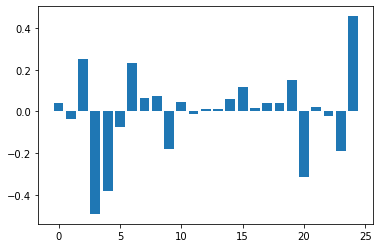

In [115]:
# get importance
importance = logistic_reg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

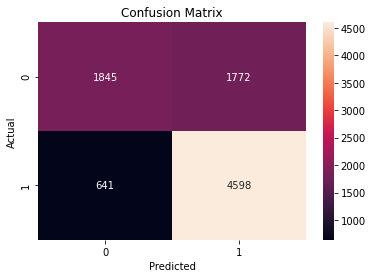

TP: 4598
TN: 1845
FP: 1772
FN: 641
Classification Accuracy: 0.7275293586269196
F1 Score: 0.7921440261865794
AUC Score: 0.6938698210075926


In [91]:
accuracy_score_logistic_reg = model_evaluation(logistic_reg, ytest, y_pred_class, True)

model_scores['LogitClassifier'] = accuracy_score_logistic_reg[1] * 100


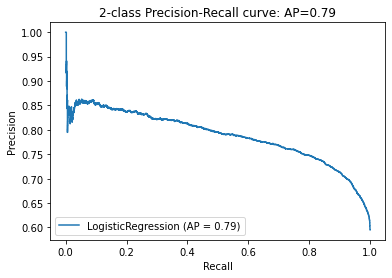

In [93]:
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import average_precision_score
y_score= logistic_reg.predict_proba(xtest)[:,1]

precision, recall, threshold = precision_recall_curve(ytest, y_score)
fpr, tpr, thresholds = roc_curve(ytest, y_score)

average_precision = average_precision_score(ytest, y_score)
disp = plot_precision_recall_curve(logistic_reg, xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

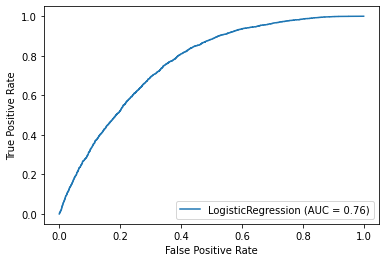

In [94]:
plot_roc_curve(logistic_reg, xtest, ytest)
plt.show()

In [96]:
def threshold_optimization(model_name, test_features, test_labels, thresholds_list):
  '''
  This function calculates the classification model performance at different 
  threshold value.
  '''
  pred_proba_df = pd.DataFrame(model_name.predict_proba(test_features))
  for i in thresholds_list:
      print ('\n******** For Threshold = {} ******'.format(i))
      Y_test_pred = pred_proba_df[1].map(lambda x: 1 if x>i else 0)
      confusion = confusion_matrix(test_labels, Y_test_pred)
      TP = confusion[1, 1]
      TN = confusion[0, 0]
      FP = confusion[0, 1]
      FN = confusion[1, 0]
      f1= f1_score(test_labels, Y_test_pred)

      print('TP:', TP)
      print('TN:', TN)
      print('FP:', FP)
      print('FN:', FN)
      print(f'F-1 Score with threshold {i} is: {f1}')

In [97]:
threshold_list = [0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
threshold_optimization(logistic_reg ,xtest, ytest, threshold_list)


******** For Threshold = 0.2 ******
TP: 5107
TN: 929
FP: 2688
FN: 132
F-1 Score with threshold 0.2 is: 0.7836427804204389

******** For Threshold = 0.3 ******
TP: 4948
TN: 1341
FP: 2276
FN: 291
F-1 Score with threshold 0.3 is: 0.7940303297761374

******** For Threshold = 0.4 ******
TP: 4811
TN: 1585
FP: 2032
FN: 428
F-1 Score with threshold 0.4 is: 0.796391325939414

******** For Threshold = 0.45 ******
TP: 4726
TN: 1709
FP: 1908
FN: 513
F-1 Score with threshold 0.45 is: 0.7960919733849913

******** For Threshold = 0.5 ******
TP: 4598
TN: 1845
FP: 1772
FN: 641
F-1 Score with threshold 0.5 is: 0.7921440261865794

******** For Threshold = 0.55 ******
TP: 4437
TN: 2015
FP: 1602
FN: 802
F-1 Score with threshold 0.55 is: 0.7868416385884022

******** For Threshold = 0.6 ******
TP: 4148
TN: 2225
FP: 1392
FN: 1091
F-1 Score with threshold 0.6 is: 0.7696446794693385

******** For Threshold = 0.7 ******
TP: 3131
TN: 2749
FP: 868
FN: 2108
F-1 Score with threshold 0.7 is: 0.6778523489932886

****

<b>As classification threshold increse F-1 Score also increases. But False Negative (defaulter customer identified as good customer) also inreases. Which could be coslty to the business. An optimum threshold has to be chosen. </b>

(0.0, 1.0)

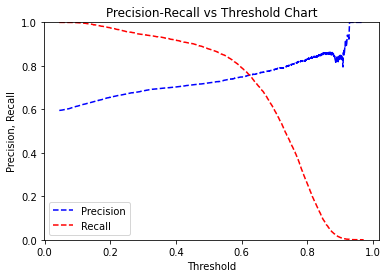

In [98]:
### Predict test_y values and probabilities based on fitted logistic regression model

pred_y=logistic_reg.predict(xtest) 

probs_y=logistic_reg.predict_proba(xtest) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first   column of  array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(ytest, probs_y[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

## Neural Networks


In [99]:
# Model using Artificial Neural Networks
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

#Fit ANN model to data
startTrain= time.time()
model = Sequential()
model.add(Dense(activation = 'relu', kernel_initializer= 'uniform', units = 40, input_dim= 25))
model.add(Dropout(rate= 0.01))
model.add(Dense(activation = 'relu', kernel_initializer= 'uniform', units = 40))
model.add(Dense(activation = 'relu', kernel_initializer= 'uniform', units = 20))
model.add(Dense(activation = 'sigmoid', kernel_initializer= 'uniform', units =1))
model.compile(optimizer=SGD(lr=0.005, momentum=0.9), loss= 'binary_crossentropy', metrics=['accuracy'])
model.fit(np.array(xtrain), np.array(ytrain), batch_size=32, epochs=100, callbacks=early_stopping_callback)
endTrain = time.time()



print("ANN training time (secs) {0}".format(endTrain - startTrain))

#Predicting using ANN
Ypred = model.predict_classes(np.array(xtest))



Epoch 1/100
646/646 [==============================] - 12s 1ms/step - loss: 0.6821 - accuracy: 0.5832
Epoch 2/100
646/646 [==============================] - 1s 1ms/step - loss: 0.6766 - accuracy: 0.5875
Epoch 3/100
646/646 [==============================] - 1s 1ms/step - loss: 0.6115 - accuracy: 0.6745
Epoch 4/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5513 - accuracy: 0.7333
Epoch 5/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5392 - accuracy: 0.7287
Epoch 6/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5340 - accuracy: 0.7291
Epoch 7/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5245 - accuracy: 0.7372
Epoch 8/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5294 - accuracy: 0.7334
Epoch 9/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5236 - accuracy: 0.7395
Epoch 10/100
646/646 [==============================] - 1s 1ms/step - loss: 0.5283 - accur

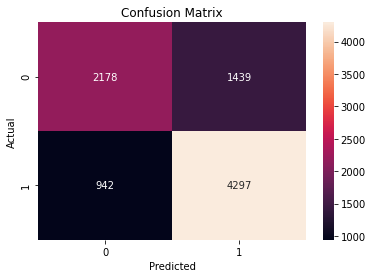

TP: 4297
TN: 2178
FP: 1439
FN: 942
Classification Accuracy: 0.7311427280939476
F1 Score: 0.7830523917995444
AUC Score: 0.711175588458628


In [100]:
accuracy_score_NeuralNet = model_evaluation(model, np.array(ytest), Ypred, True)

model_scores['NueralNets'] = accuracy_score_NeuralNet[1] * 100

# Performance Comparison

In [101]:
model_scores

{'LogitClassifier': 69.38698210075927,
 'NueralNets': 71.1175588458628,
 'Random Forest': 70.56242174250534,
 'XGBClassifier': 70.44096183622723,
 'XGBoost_CV': 70.7154208011066}

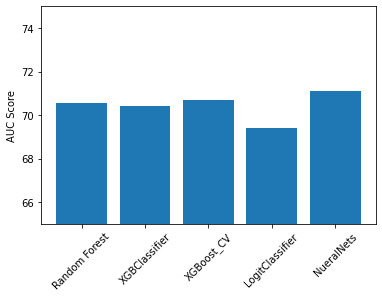

In [102]:
names = list(model_scores.keys())
values = list(model_scores.values())
plt.bar(range(len(model_scores)), values, tick_label=names)
plt.xticks(rotation=45)
plt.ylabel('AUC Score')
plt.ylim([65.0, 75.0])
plt.show()

<b>Neural Networks has performed better in the validation dataset in terms of AUC Score. </b>


In [118]:
from mlxtend.evaluate import paired_ttest_5x2cv
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=logistic_reg, estimator2=random_forest, X=xtest, y=ytest, scoring='accuracy', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))
# interpret the result
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

P-value: 0.506, t-Statistic: 0.715
Algorithms probably have the same performance


# Train a Lighter Model for App

In [104]:
# Selection of features based on feature importance scores by different models
cols= ['apr', 'clearfraudscore', 'ssnLoanCount', 'log_loanAmount', 'log_nPaidOff',
       'payFrequency_B', 'payFrequency_I', 'payFrequency_M', 'payFrequency_S', 'payFrequency_W']

# Separate input features and target
x_data_selected = data[cols]
y_data = data['target'].astype('category')

In [105]:
# Shuffle and split data into 70% in training and 30% in testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data_selected, y_data,random_state=123, test_size=0.30)

In [106]:
#training a new lighter Logistic Regression with selected features
log_reg_selected_features= LogisticRegression()
log_reg_selected_features.fit(x_train, y_train)
y_pred_class = log_reg_selected_features.predict(x_test)
log_reg_selected_features.score(x_test,y_test)

0.7121725383920506

In [119]:
# Download the model with pickle
import pickle
# open a file, where to store the data
file = open('logistic_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(log_reg_selected_features, file)

# Python Libraries used in this Notebook

In [110]:
#Python packages used in this notebook
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'IPython.core.shadowns',
 'pandas',
 'numpy',
 'matplotlib.pyplot',
 'seaborn',
 'warnings',
 'sklearn.metrics',
 'keras',
 'time',
 'pickle',
 'pipreqs',
 'types']

In [109]:
!pip freeze > requirements1.txt

## Improvements
*This analysis has been carried out based on the data available from previous loan accounts, which are mostly related to the individual borrower. There may be other factors/features that could better predict the credit risks. Country-related risks such as sudden political instability or downfall of the overall economic situation of the country may affect a person or entity's ability to repay the loan. Other cases, such as the invention of new technology, can kill a traditional industry. Businesses and people working in that industry will suddenly become jobless. These situations will impact their ability to repay the loan even if they had a perfect credit history or paid off the loan on time in the past.

*The financial institutions, banks, and lenders can adjust the cost of credit, carry out risk-based pricing, reduce credit amount to the high-risk buyers, tight the credit provision, purchase the credit insurance or derivatives, and much more to curb the menace.

*Many studies have found debt to income ratio is a clear indicator of the borrowers' ability to repay the loan. Including customer income, data could improve the model.

*Feature Selection was not done for Neural Network Model. Important features identified from Random Forest and XGBoost can be used to reduce the dimension.

*There are no straight forward rule for Neural Network model architecture. It requires more trial and error to come up with a better model.

*Random Forest itself a kind of ensemble model. Stacking modeling methods (train different models and use their predictions as features in another model) could be used for better performance.

*QuantileTransformer reduces the effect of outlier. However,  completely removing outliers from the dataset could improve the model.


*Reduce false positives and false negatives. It depends on the business objectives, which one to prioritize. If the business goal is to reduce loss, then falsely identifying a customer as good but who is actually a defaulter could lead to capital loss. Again, falsely classifying a defaulter who is actually a good customer, is an opportunity loss.

## Summary
In this report, we achieved 0.71 AUC score in determining whether a loan will be defaulted or not. We explored past loan performance and understood what kind of people are more likely to default. Neural Network has performed better in the validation dataset in terms of AUC Score. However, the differences in accuracy between these models are not significant.

Financial industry is highly regulated. So model interpretability is a huge factor. Therefor I would reccomend to use Random forest or Logistic regression for deployment.

We have used some selected features to create a loan prediction app for demonstration purpose with a logistic regression model. 
